In [1]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

sys.path.append("/home/wangrr/Analysis/epiRNA/src")
workdir = "/data/wangrr/Analysis/epiRNA/workdir2/benchmark"
os.makedirs(workdir, exist_ok=True); os.chdir(workdir)
warnings.filterwarnings("ignore", category=UserWarning)

import epiRNA as erna

In [2]:
# model config:
config = "/home/wangrr/Analysis/epiRNA/src/experiments/model_v2/configs/basic_model.yaml"

# model checkpoint:
ckpt_dir = "/data/wangrr/Analysis/epiRNA/models"
checkpoints = {
    "complete": f"{ckpt_dir}/basic_fold/version_0/checkpoints/epoch=18-step=215327-val_ePCC_mixed=0.7823.ckpt",
    "human": f"{ckpt_dir}/v2human_only/version_0/checkpoints/epoch=13-step=76594-val_ePCC_mixed=0.7087.ckpt",
    "mouse": f"{ckpt_dir}/v2mouse_only/version_0/checkpoints/epoch=08-step=52749-val_ePCC_mixed=0.7269.ckpt"
}

# load models
model_zoo = {}
for key, ckpt in checkpoints.items():
    model = erna.evals.load_model(ckpt, config)
    model.eval()
    model_zoo[key] = model

In [3]:
datainfo = pd.read_excel("/home/wangrr/Analysis/epiRNA/data/mRNA_multiomic_sample_info.xlsx", sheet_name="m6A")

human_samples = ["Adipose-1", "Aorta-1", "Appendix-1", "Esophagus-1", "GOS-1", "Hela-1", "HT29-1", "Hypothalamus-1", "Jejunum-1", "Liver-1", "Prostate-1", "Skin-1", "Testis-1", "Tongue-1", "Trachea-1", "WPMY-1", "MT4-1", "GSC11-1", "iSLK-1", "TIME-1"]
mouse_samples = ["mHeart-1", "mSpleen-1", "mLung-1", "mLiver-1", "mCerebrum-1", "mCerebellum-1", "mBrainstem-1", "mHypothalamus-1", "mBMDC-1", "mEF-1", "mNPC-1", "mESC-1", "mStriatum-1", "mPeritoneal_macrophages-1", "mB16-OVA-1", "miPSC-1", "mNSC-1", "mForebrain-1", "mKidney-1", "mHypothalamus-2"]

human_datainfo = datainfo[datainfo["SID"].isin(human_samples)].reset_index(drop=True).copy()
mouse_datainfo = datainfo[datainfo["SID"].isin(mouse_samples)].reset_index(drop=True).copy()

ref_dir = "/data/wangrr/Analysis/epiRNA/Dataset/Reference"
genome = {
    "human":{
        "fasta": f"{ref_dir}/Homo_sapiens.GRCh38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Homo_sapiens.GRCh38.84.gtf"
    },
    "mouse":{
        "fasta": f"{ref_dir}//Mus_musculus.GRCm38.dna.primary_assembly.84.fa",
        "gtf": f"{ref_dir}/Mus_musculus.GRCm38.84.gtf"
    }
}

human_gtf_df = erna.pp.GTFLoader(gtf_path=genome["human"]["gtf"], zero_based=True)
mouse_gtf_df = erna.pp.GTFLoader(gtf_path=genome["mouse"]["gtf"], zero_based=True)

chrom_kwargs = {
    'human': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    },
    'mouse': {
        'train_chroms': ["1", "2", "3", "4", "5", "6", "7", "9", "11", "12", "13", "14", "15", "16", "17", "18", "19"],
        'val_chroms': ["8"],
        'test_chroms': ["10"]
    }
}

import pickle
with open("/home/wangrr/Analysis/epiRNA/data/rbp_expression_dict.pkl", "rb") as f:
    rbp_dict = pickle.load(f)['rbp_dict']
bigwig_dir = "/data/wangrr/Analysis/epiRNA/Dataset/processed/4-coverage"

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']
INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [4]:
human_fasta_loader = erna.pp.FastaLoader(genome["human"]["fasta"])
mouse_fasta_loader = erna.pp.FastaLoader(genome["mouse"]["fasta"])

mouse_generator = erna.pp.DataGenerator(
    fasta_loader=mouse_fasta_loader,
    gtf_df=mouse_gtf_df,
    seq_len=65536,
    bin_size=64
)

human_generator = erna.pp.DataGenerator(
    fasta_loader=human_fasta_loader,
    gtf_df=human_gtf_df,
    seq_len=65536,
    bin_size=64
)

In [5]:
# help function to get prediction from given sample-gene pairs using given model
def get_predictions(model, sample, gene, rbp_dict, mask_type, device="cuda:0"):
    sample_info = datainfo[datainfo["SID"]==sample].iloc[0]
    species = sample_info["Species"]
    rbp_exp = rbp_dict[sample]
    
    generator = human_generator if species=="Human" else mouse_generator
    gtf_df = human_gtf_df if species=="Human" else mouse_gtf_df
    
    gene_row = gtf_df[gtf_df["gene_name"]==gene].iloc[0]
    input_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "Input", f"{sample}.bigwig"))
    ip_bw = erna.pp.BigWigLoader(os.path.join(bigwig_dir, "m6A", "IP", f"{sample}.bigwig"))
    data = generator.generate(
        gtf_row=gene_row,
        input_bwloader=input_bw,
        ip_bwloader=ip_bw,
        return_bin_input=True,
        mask_type=mask_type
    )
    
    head = 0 if species=="Human" else 1
    
    input_x = torch.tensor(data["input"]).unsqueeze(0).to(device, dtype=torch.float32)
    head_idx = torch.tensor(head).unsqueeze(0).to(device, dtype=torch.long)
    rbp_x = torch.tensor(rbp_exp).unsqueeze(0).to(device, dtype=torch.float32)
    with torch.no_grad():
        preds, attns = model(input_x, rbp_x, head_idx)
        
    preds = preds.squeeze(0).cpu()
    pcc_rna_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["bin_input"]),
        torch.from_numpy(data["target"])
    )
    pcc_pred_ip = erna.nn.safe_pearson_corrcoef(
        torch.from_numpy(data["target"]),
        preds
    )
    loss_rna_ip = nn.MSELoss()(torch.from_numpy(data["bin_input"]), torch.from_numpy(data["target"])).item()
    loss_pred_ip = nn.MSELoss()(torch.from_numpy(data["target"]), preds).item()
    return {
        "gene": gene,
        "chrom": data['region']['chrom'],
        "strand": gene_row['strand'],
        "requested_start": data['region']['requested_start'],
        "requested_end": data['region']['requested_end'],
        "species": species,
        "sample": sample,
        "preds": preds.numpy(),
        "bin_input": data["bin_input"],
        "target": data["target"],
        "pcc_rna_ip": pcc_rna_ip,
        "pcc_pred_ip": pcc_pred_ip,
        "loss_rna_ip": loss_rna_ip,
        "loss_pred_ip": loss_pred_ip
    }
    

In [ ]:
human_gtf_in_valtest = human_gtf_df[human_gtf_df['chrom'].isin(chrom_kwargs['human']['val_chroms'] + chrom_kwargs['human']['test_chroms'])]

mouse_gtf_in_valtest = mouse_gtf_df[mouse_gtf_df['chrom'].isin(chrom_kwargs['mouse']['val_chroms'] + chrom_kwargs['mouse']['test_chroms'])]

# found homologous genes in human and mouse in val/test chroms
human_genes = set(human_gtf_in_valtest['gene_name'].unique())
mouse_genes = set(mouse_gtf_in_valtest['gene_name'].unique())
mouse_genes_fullcap = set([gene.upper() for gene in mouse_genes])
homologous_genes = list(human_genes.intersection(mouse_genes_fullcap))

In [43]:
print(homologous_genes)

['NRBF2', 'EGR2', 'TDRP', 'PDGFRL', 'IPMK', 'CSMD1', 'ADRB3', 'LETM2', 'SUPV3L1', 'DDHD2', 'HK1', 'VPS37A', 'SLC16A9', 'ASAH1', 'TSPAN15', 'MYOM2', 'GINS4', 'CDH23', 'RTKN2', 'PCBD1', 'AGPAT5', 'COL13A1', 'NEUROG3', 'ANK3', 'PLA2G12B', 'SPOCK2', 'PCM1', 'UBXN8', 'DUSP26', 'SLC29A3', 'PPA1', 'SLC7A2', 'HERC4', 'CHRNB3', 'PPP2CB', 'ERICH1', 'CCAR1', 'ZMAT4', 'INTS10', 'ARHGEF10', 'WHSC1L1', 'KBTBD11', 'ADO', 'THAP1', 'ARID5B', 'ASH2L', 'SGCZ', 'DEFA5', 'ADAM32', 'GOLGA7', 'EIF4EBP2', 'BICC1', 'DDIT4', 'TNKS', 'NRP1', 'HOOK3', 'IKBKB', 'OIT3', 'VPS26A', 'FUT10', 'TFAM', 'GTF2E2', 'MAK16', 'ANAPC16', 'ATOH7', 'ATP6V1B2', 'SH2D4A', 'ADAM9', 'SRGN', 'RBPMS', 'NAT2', 'SPAG11A', 'TBATA', 'JMJD1C', 'ADAMTS14', 'DKK4', 'LEPROTL1', 'NPFFR1', 'DLC1', 'FBXO25', 'AIFM2', 'ADAM18', 'PRF1', 'FNTA', 'ZWINT', 'TACR2', 'RNF122', 'RAB11FIP1', 'TM2D2', 'CCDC6', 'SARAF', 'WRN', 'SPAG11B', 'PLAT', 'PPP1R3B', 'LRRC20', 'MTUS1', 'SGPL1', 'ANK1', 'DUSP4', 'UNC5D', 'PSAP', 'LZTS1', 'HGSNAT', 'ITGB1', 'LRRTM3', '

In [98]:
human_sample = "Liver-1"
mouse_sample = "mLiver-1"
human_gene = "GPAT4"
mouse_gene = human_gene.lower().capitalize()
human_gene, mouse_gene

('GPAT4', 'Gpat4')

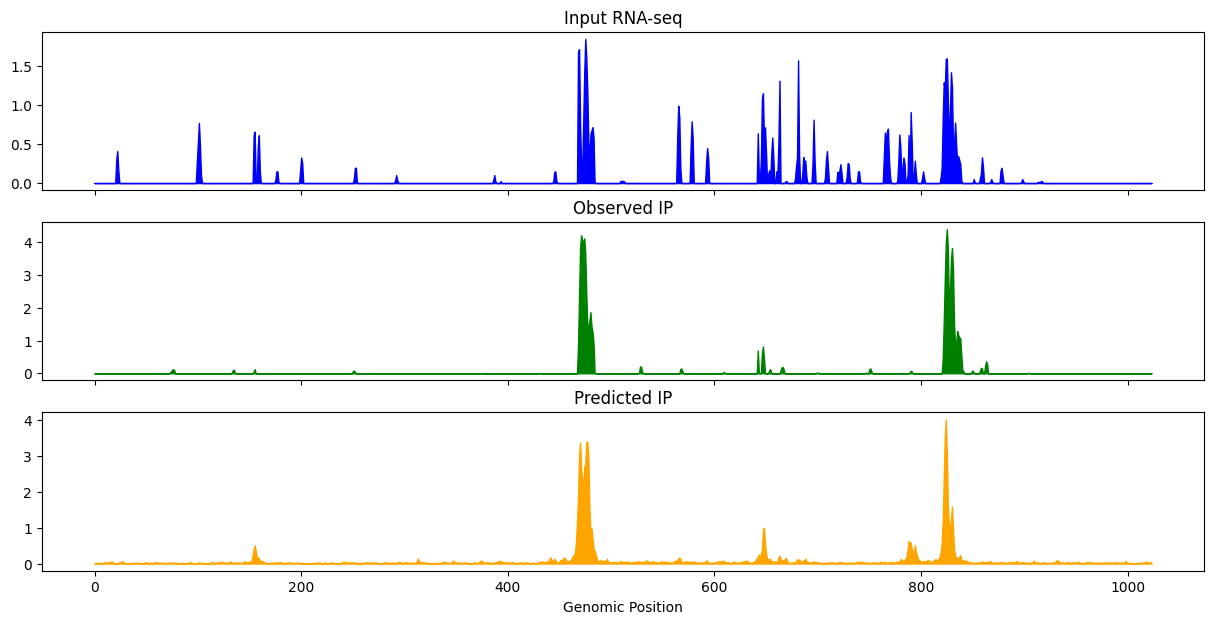

{'gene': 'GPAT4',
 'chrom': '8',
 'strand': '+',
 'requested_start': 41568326,
 'requested_end': 41633862,
 'species': 'Human',
 'sample': 'Liver-1',
 'preds': array([0.01340234, 0.02416427, 0.01556293, ..., 0.02325426, 0.02541249,
        0.04112528], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.6636),
 'pcc_pred_ip': tensor(0.8574),
 'loss_rna_ip': 0.13632915914058685,
 'loss_pred_ip': 0.06188435107469559}

In [99]:
human_out = get_predictions(
    model_zoo['complete'].cuda(), 
    sample=human_sample, 
    gene=human_gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)
erna.pl.multiple_tracks_plot(
    input_obs=human_out['bin_input'],
    ip_obs=human_out['target'],
    ip_pred=human_out['preds'],
    actmap=None,
    figsize=(15,7)
)
human_out

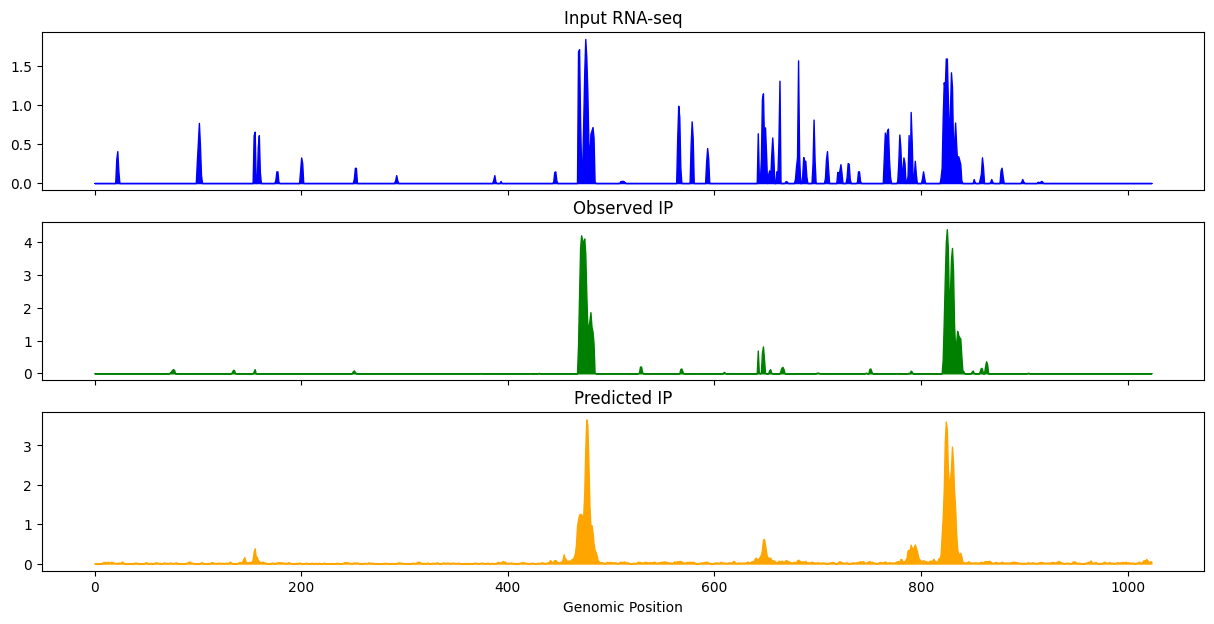

{'gene': 'GPAT4',
 'chrom': '8',
 'strand': '+',
 'requested_start': 41568326,
 'requested_end': 41633862,
 'species': 'Human',
 'sample': 'Liver-1',
 'preds': array([0.00997459, 0.00919062, 0.01003493, ..., 0.039464  , 0.05937373,
        0.04384266], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.6636),
 'pcc_pred_ip': tensor(0.8587),
 'loss_rna_ip': 0.13632915914058685,
 'loss_pred_ip': 0.06217280775308609}

In [100]:
humanonly_out = get_predictions(
    model_zoo['human'].cuda(), 
    sample=human_sample, 
    gene=human_gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)
erna.pl.multiple_tracks_plot(
    input_obs=humanonly_out['bin_input'],
    ip_obs=humanonly_out['target'],
    ip_pred=humanonly_out['preds'],
    actmap=None,
    figsize=(15,7)
)
humanonly_out

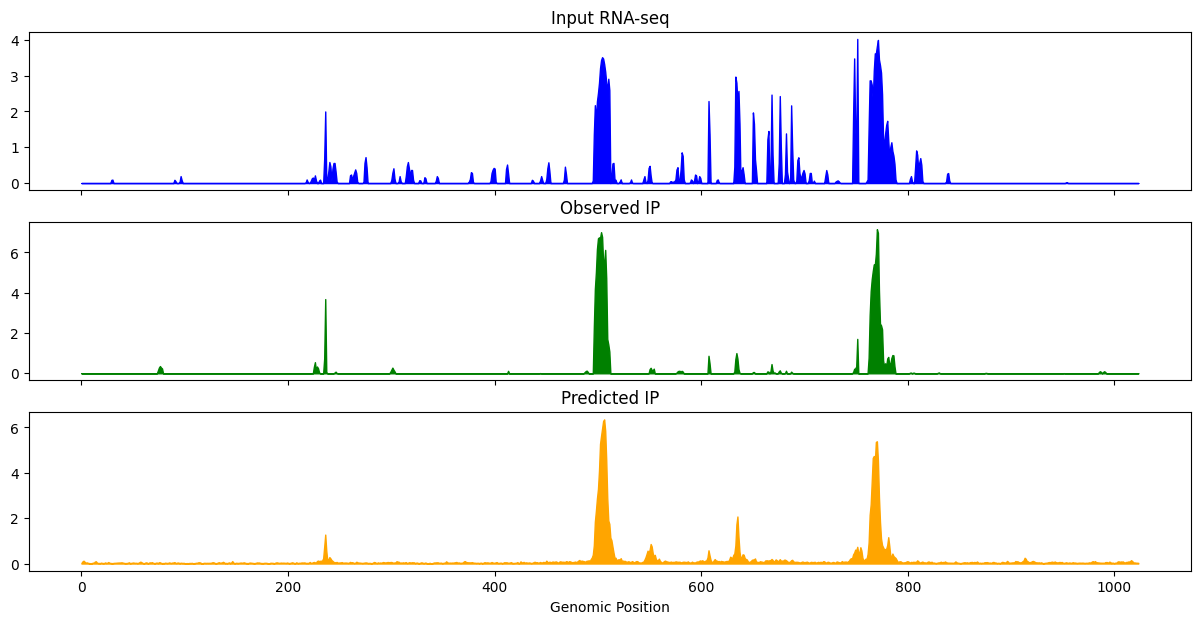

{'gene': 'Gpat4',
 'chrom': '8',
 'strand': '-',
 'requested_start': 23157931,
 'requested_end': 23223467,
 'species': 'Mouse',
 'sample': 'mLiver-1',
 'preds': array([0.0246968 , 0.09341647, 0.12395979, ..., 0.03231645, 0.03359262,
        0.02823018], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.8049),
 'pcc_pred_ip': tensor(0.9448),
 'loss_rna_ip': 0.2633098065853119,
 'loss_pred_ip': 0.09604448080062866}

In [101]:
mouse_out = get_predictions(
    model_zoo['complete'].cuda(), 
    sample=mouse_sample, 
    gene=mouse_gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)
erna.pl.multiple_tracks_plot(
    input_obs=mouse_out['bin_input'],
    ip_obs=mouse_out['target'],
    ip_pred=mouse_out['preds'],
    actmap=None,
    figsize=(15,7)
)
mouse_out

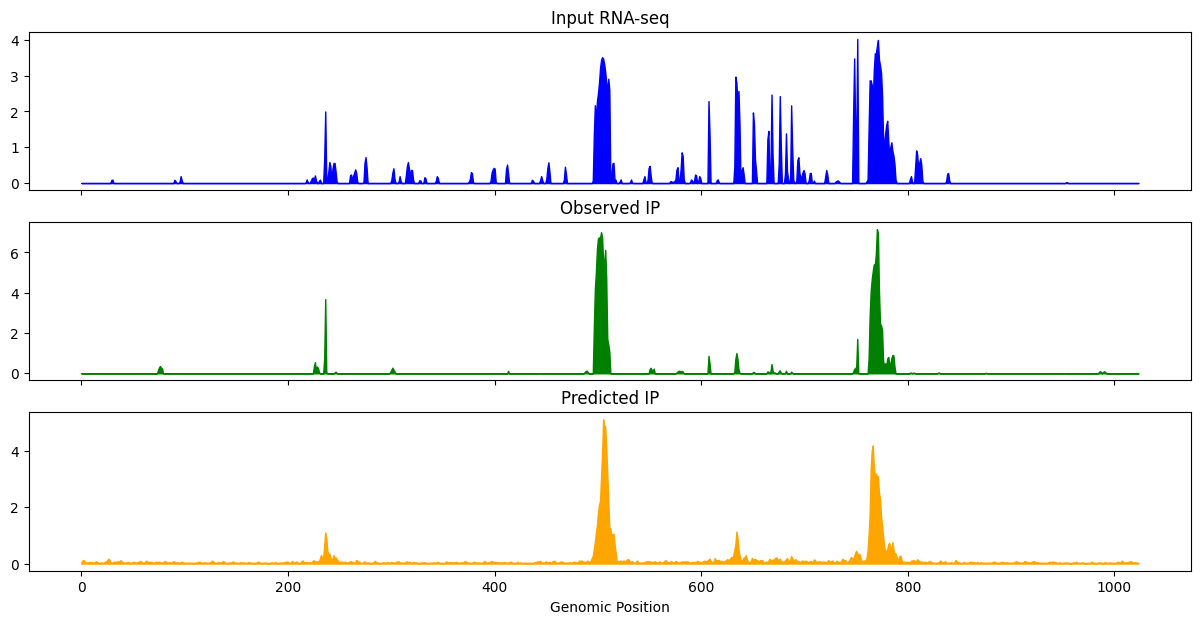

{'gene': 'Gpat4',
 'chrom': '8',
 'strand': '-',
 'requested_start': 23157931,
 'requested_end': 23223467,
 'species': 'Mouse',
 'sample': 'mLiver-1',
 'preds': array([0.04871024, 0.11019769, 0.12184148, ..., 0.03825853, 0.03112089,
        0.01776973], dtype=float32),
 'bin_input': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'target': array([0., 0., 0., ..., 0., 0., 0.], dtype=float32),
 'pcc_rna_ip': tensor(0.8049),
 'pcc_pred_ip': tensor(0.8827),
 'loss_rna_ip': 0.2633098065853119,
 'loss_pred_ip': 0.22009651362895966}

In [102]:
mouseonly_out = get_predictions(
    model_zoo['mouse'].cuda(), 
    sample=mouse_sample, 
    gene=mouse_gene, 
    rbp_dict=rbp_dict, 
    mask_type=None, 
    device="cuda"
)
erna.pl.multiple_tracks_plot(
    input_obs=mouseonly_out['bin_input'],
    ip_obs=mouseonly_out['target'],
    ip_pred=mouseonly_out['preds'],
    actmap=None,
    figsize=(15,7)
)
mouseonly_out